In [ ]:
# The purpose of this project is to identify if it is possible to determine 10 
# different animals distinctly. 

# I am using a dataset from kaggle.com that contains 10 folders. These folders 
# include images scraped from google based on the animal choosen. Some folders 
# have as few as 1400 images, where others have upto 4500 images.


# https://www.kaggle.com/datasets/alessiocorrado99/animals10


In [ ]:
pip install scikeras[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd       # by Isaac Rodriguez
import numpy as np
from keras import layers, models
from google.colab import files
import zipfile
import PIL
from PIL import Image
import glob
from keras.layers import Dropout, BatchNormalization
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras import layers, models
from keras import callbacks

In [ ]:
uploaded = files.upload() # uploads compressed data

Saving raw-img.zip to raw-img.zip


In [ ]:
for fn in uploaded.keys():
  name = fn
zfile = zipfile.ZipFile(name, 'r')   # unzip the directory 
zfile.extractall()

In [ ]:
# Since many images are differernt sizes, i decided to crop them all into a standard size
# this is important because the neural network needs common size images in order to process them.

# This function takes an image and crops from the center, a sqaure of size 150 by 150
# this function assumes all images are greater than 150,150

def standardPicSize(picture):
  img_width, img_height = picture.size    # finds image size
  w,h = 150,150   # desired image size
  left, right = (img_width - w) / 2, (img_width + w) / 2    # left and right positions to crop
  top, bottom = (img_height - h) / 2, (img_height + h) / 2    # top and bottom postions to crop
  left, top = round(max(0, left)), round(max(0, top))         # compares left and top to zero and removes decimals
  right, bottom = round(min(img_width - 0, right)), round(min(img_height - 0, bottom))    # compares to see which is smaller, original 
                                                                                          # image width or right crop postion. Same with 
                                                                                          # bottom postion. then removes decimals
  picture = picture.crop((left, top, right, bottom))    # crops image
  img_width, img_height = picture.size  # picture size after crop
  if (img_width < 150):      #
    picture = 0              #
  if (img_height < 150):     # drop images with dimensions less than 150x150
    picture = 0              #
  return picture

In [ ]:
## This block of code takes the folders of pictures in the unzipped data
## and extracts one by one by putting them into a list and saving what kind 
## of animal the picture is. Once the list is finished, they are converted to arrays

images = [] 
# this is the alphabetical order the folders are saved in the zip file.
animals = ['butterfly','cat','chicken','cow','dog','elephant','horse','sheep','spider','squirrel']
#animals = ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

target = []
for folders in animals:   # goes through folders that are included in animals
  for f in glob.iglob('/content/raw-img/'+ str(folders) +'/*.jpeg'): # extracts image
    im = Image.open(f)
    im = standardPicSize(im)      # makes all images same size
    if (im != 0):        # drop images with dimensions less than 150x150
      images.append(np.asarray(im))    # adds image to images list
      target.append(folders)    # adds whats kind of animal image is to another list

X = np.array(images)            #  Array of images    
y = np.array(target)          #  Array of animal names in line with X

In [ ]:
# Take the data and splits it up into training and testing sets
# in this case I decided to shuffle the data to avoid the model seeing too much 
# of the same animal at once.
X = X[0:-1]
y = y[0:-1]
Y = pd.get_dummies(y)
X_train, X_remaining, y_train, y_remaining = train_test_split(X,Y,shuffle=True, train_size = 0.8)
X_val, X_test, y_val, y_test = train_test_split(X_remaining,y_remaining, test_size=0.10)

# X_train = X_train.astype('float32')/255   #
# X_test = X_test.astype('float32')/255     # scale down pixel values
# X_val = X_test.astype('float32')/255      #    Takes up too much ram  


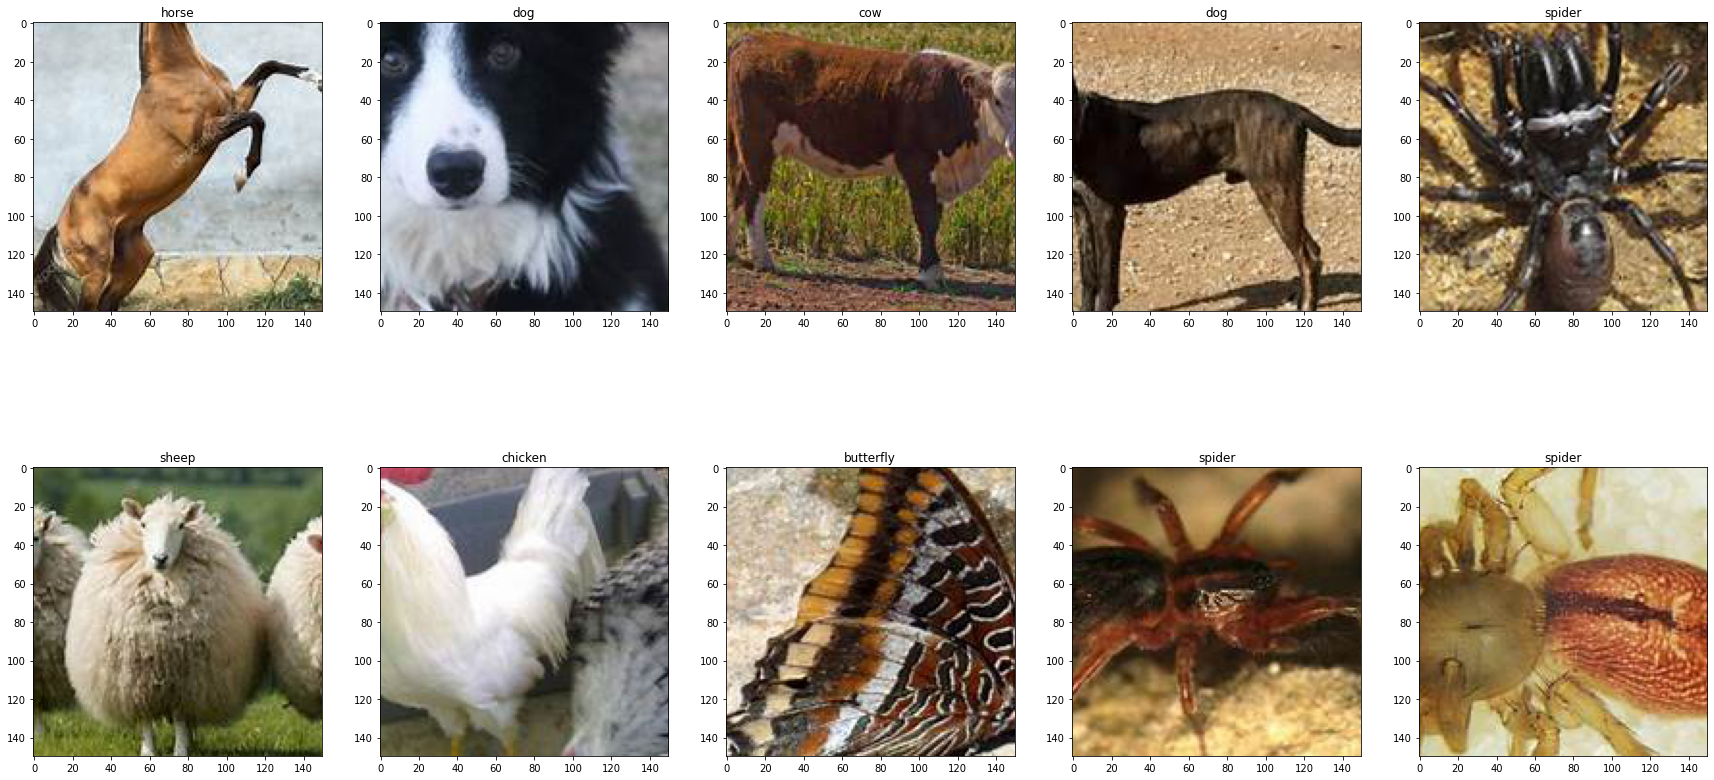

In [ ]:
# displays first 10 pictures in X_train
f = plt.figure(figsize=(30,15))   # makes figure bigger
for i in range(10):                 # 
  ax = f.add_subplot(2, 5, i+1)     # displays 10 sub figures
  ax.title.set_text(str(y[y_train.index[i]])) #
  ax.imshow(X_train[i])             #

In [ ]:
#
# Simple Convolutional Neural Network with GridSearch capabilities
# This is a simple network taken from "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow by Aurelien Geron"
# The basic structure is taken from this book but i have added GridSearch in order to determine best hyper parameters.
#

def cnn_model():  
  model_layers = [
    layers.Conv2D(32,(3,3), padding='same', input_shape=[150,150,3]),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2,padding='same'),
    layers.Dropout(0.3),

    layers.Conv2D(64,(3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2,padding='same'),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(10,activation='softmax')
  ]
  model_original = models.Sequential(model_layers)

  model_original.compile(loss='categorical_crossentropy',optimizer='rmsprop', metrics=['categorical_accuracy']) 
  return model_original


In [ ]:
classifier_cnn = KerasClassifier(model=cnn_model)

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 3, restore_best_weights = True)
hist = classifier_cnn.fit(X_train, y_train, batch_size=64, epochs = 15,validation_data =(X_val, y_val), callbacks =[earlystopping])

Epoch 1/15
299/299 [==============================] - 961s 3s/step - loss: 2.0431 - categorical_accuracy: 0.3263 - val_loss: 1.6941 - val_categorical_accuracy: 0.4123
Epoch 2/15
299/299 [==============================] - 947s 3s/step - loss: 1.6686 - categorical_accuracy: 0.4303 - val_loss: 1.5693 - val_categorical_accuracy: 0.4542
Epoch 3/15
299/299 [==============================] - 944s 3s/step - loss: 1.5029 - categorical_accuracy: 0.4920 - val_loss: 1.4882 - val_categorical_accuracy: 0.4836
Epoch 4/15
299/299 [==============================] - 948s 3s/step - loss: 1.3619 - categorical_accuracy: 0.5441 - val_loss: 1.8997 - val_categorical_accuracy: 0.4088
Epoch 5/15
299/299 [==============================] - 943s 3s/step - loss: 1.2316 - categorical_accuracy: 0.5841 - val_loss: 1.3565 - val_categorical_accuracy: 0.5381
Epoch 6/15
299/299 [==============================] - 940s 3s/step - loss: 1.1156 - categorical_accuracy: 0.6250 - val_loss: 1.5537 - val_categorical_accuracy: 0.490

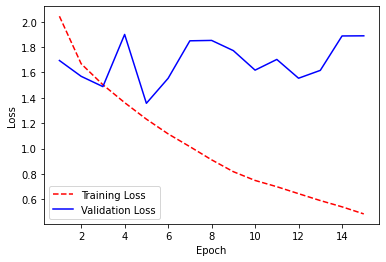

In [ ]:
#Understanding overfitting
# Get training and test loss histories
training_loss = hist.history_['loss']
test_loss = hist.history_['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
preds = classifier_cnn.predict_proba(X_test)

15/15 [==============================] - 5s 348ms/step


In [ ]:
#animals = ['dog', 'horse', 'elephant', 'butterfly','chicken', 'cat', 'cow', 'sheep', 'spider', 'squirell']
pred = classifier_cnn.predict(X_test)
print(classification_report(y_test, pred, target_names=animals))

15/15 [==============================] - 6s 357ms/step
              precision    recall  f1-score   support

   butterfly       0.78      0.45      0.57        31
         cat       0.13      0.68      0.22        22
     chicken       0.62      0.67      0.64        69
         cow       0.49      0.53      0.51        32
         dog       0.43      0.49      0.46        83
    elephant       0.28      0.29      0.29        17
       horse       0.80      0.35      0.48        46
       sheep       1.00      0.15      0.27        26
      spider       0.80      0.54      0.65       105
    squirrel       0.52      0.30      0.38        47

   micro avg       0.48      0.48      0.48       478
   macro avg       0.58      0.45      0.45       478
weighted avg       0.62      0.48      0.50       478
 samples avg       0.48      0.48      0.48       478



In [ ]:
# trabsform encoded names to english
pred = pd.DataFrame(data = pred, columns = animals) 
pred = pred.idxmax(axis=1)
y_test_names = y_test.idxmax(axis=1)

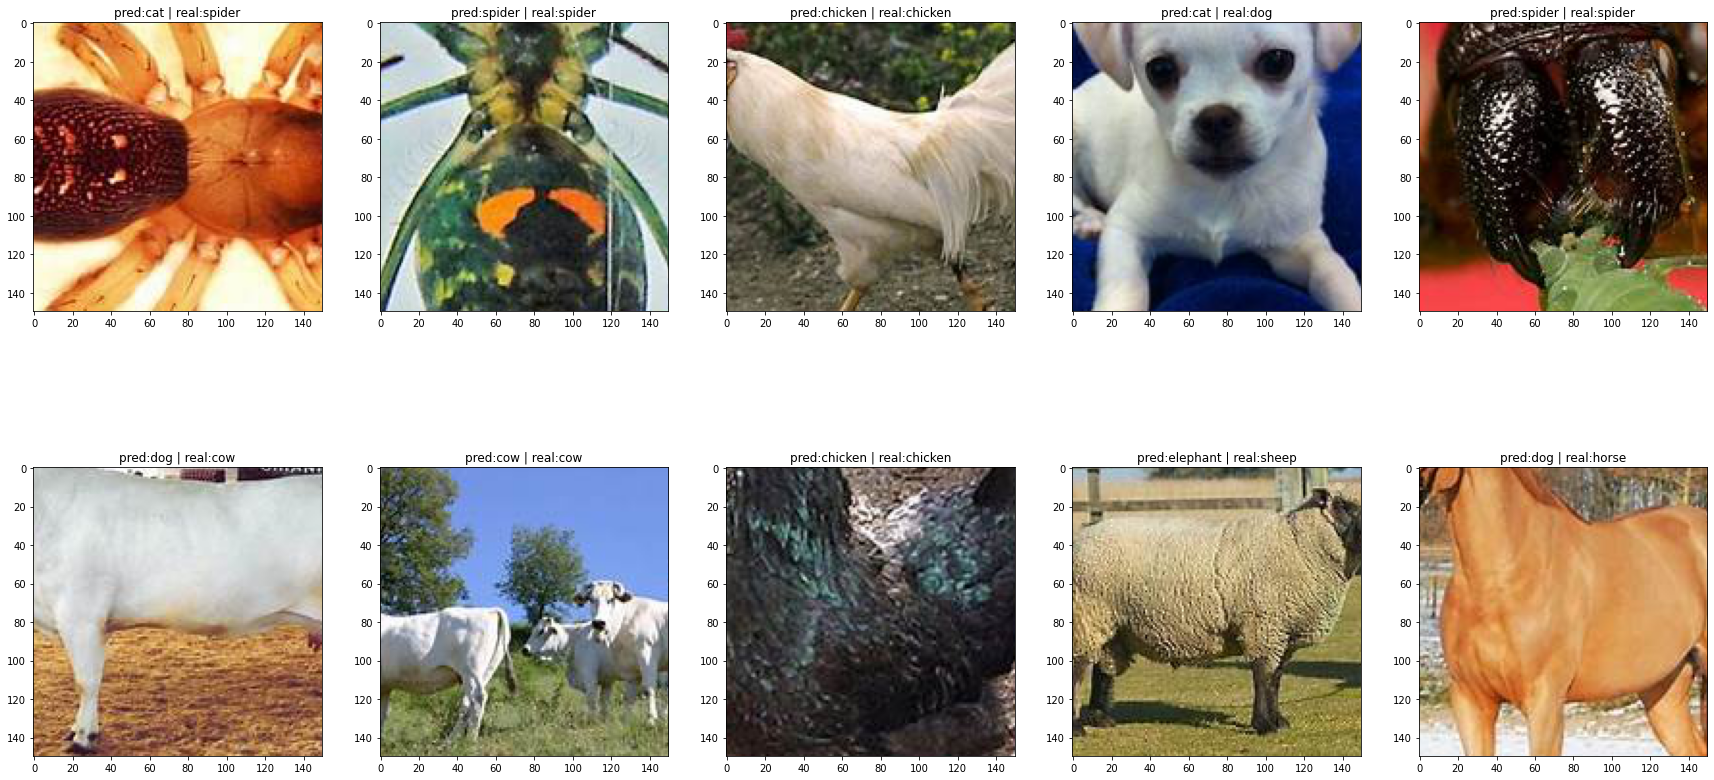

In [ ]:
# displays first 10 predictions
f = plt.figure(figsize=(30,15))   # makes figure bigger
for i in range(10):                                                              # 
  ax = f.add_subplot(2, 5, i+1)                                                  # displays 10 sub figures
  ax.title.set_text('pred:'+str(pred[i])+' | real:'+str(y_test_names.iloc[i]))   #
  ax.imshow(X_test[i])                                                           #

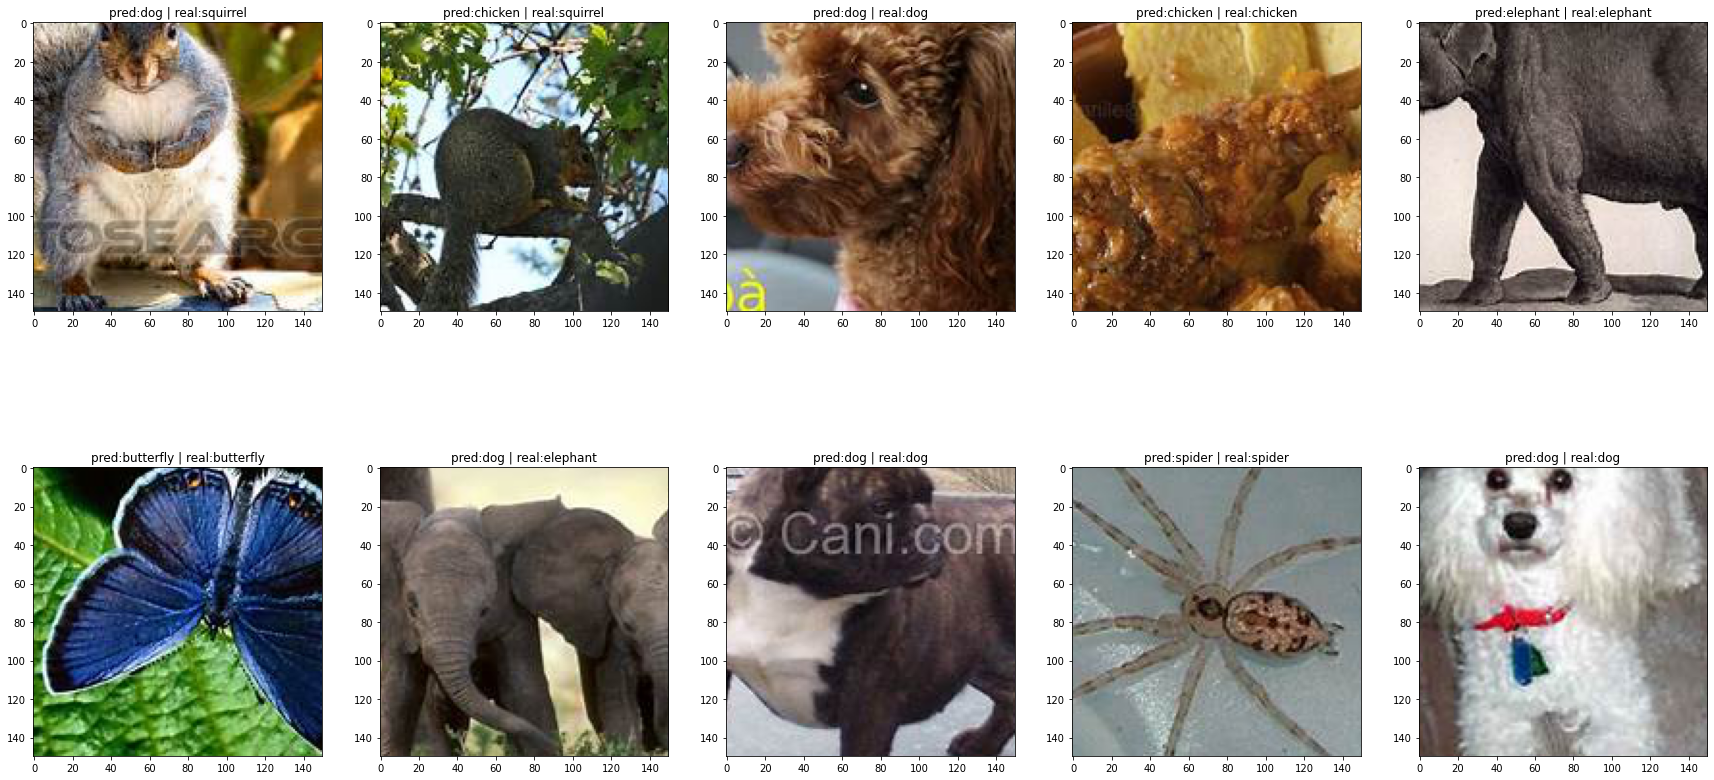

In [ ]:
# displays first 10-20 predictions
f = plt.figure(figsize=(30,15))   # makes figure bigger
for i in range(10):                                                                    # 
  ax = f.add_subplot(2, 5, i+1)                                                        # displays 10 sub figures
  ax.title.set_text('pred:'+str(pred[i+10])+' | real:'+str(y_test_names.iloc[i+10]))   #
  ax.imshow(X_test[i+10])                                                              #

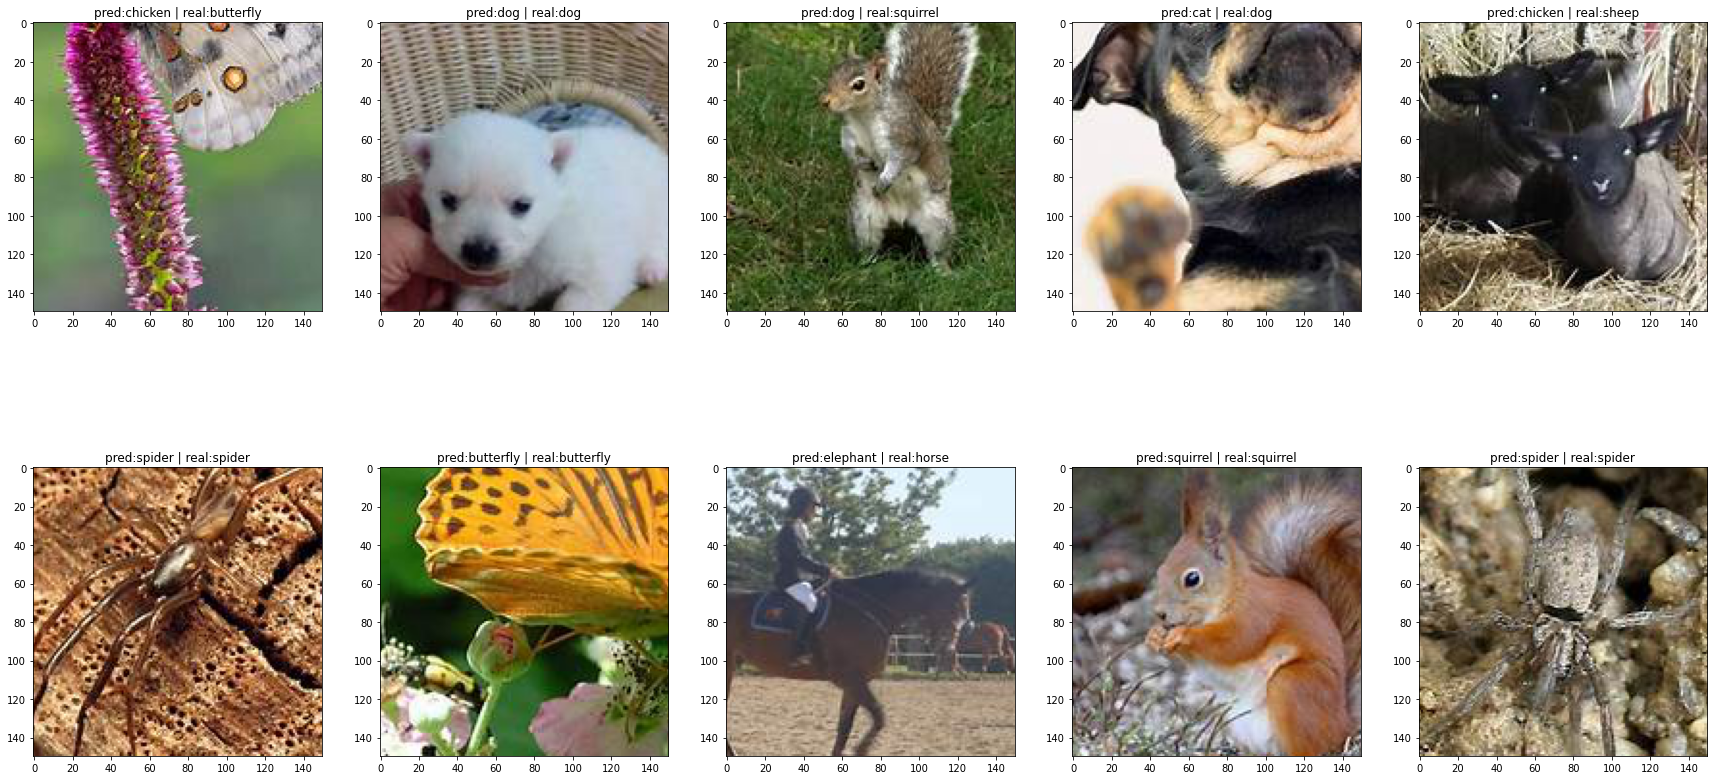

In [ ]:
# displays first 10-20 predictions
f = plt.figure(figsize=(30,15))   # makes figure bigger
for i in range(10):                 # 
  ax = f.add_subplot(2, 5, i+1)     # displays 10 sub figures
  ax.title.set_text('pred:'+str(pred[i+20])+' | real:'+str(y_test_names.iloc[i+20]))   #
  ax.imshow(X_test[i+20]) 